In [1]:
from google.colab import files
uploaded = files.upload()

Saving vodafone_datasett.csv to vodafone_datasett.csv


In [2]:
import os
import shutil
import tarfile
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
import pandas as pd
from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objects as go
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.metrics import classification_report
import pandas as pd
import unicodedata


In [3]:
# Assuming the file is uploaded successfully, load it with pandas
df = pd.read_csv('vodafone_datasett.csv',encoding="utf-8",sep=";")
print(df.head())
print(df.columns)

   Title                                        Explanation  Target  \
0    NaN  Vodafone'un hazırlamış olduğu FreeZone ve fatu...       0   
1    NaN  Vodafone 50 GB herkese verdi, bana vermedi. Be...       0   
2    NaN  Vodafone müşteri hizmetleri numarası 542 yi ar...       0   
3    NaN  Merhabalar Vodafone 50 GB hediye internet kamp...       0   
4    NaN  Merhabalar Vodafone 50 GB hediye internet kamp...       0   

                                                Link  
0  https://www.sikayetvar.com/vodafone/vodafone-f...  
1  https://www.sikayetvar.com/vodafone/vodafone-5...  
2  https://www.sikayetvar.com/vodafone/vodafone-m...  
3  https://www.sikayetvar.com/vodafone/vodafone-5...  
4  https://www.sikayetvar.com/vodafone/vodafone-5...  
Index(['Title', 'Explanation', 'Target', 'Link'], dtype='object')


In [4]:
sentiment_counts = df['Target'].value_counts()

fig =px.bar(x= {0:'Negative',1:'Positive',2:'Neutral'},
            y= sentiment_counts.values,
            color=sentiment_counts.index,
            color_discrete_sequence =  px.colors.qualitative.Dark24,
            title='<b>Sentiments Counts')

fig.update_layout(title='Sentiments Counts',
                  xaxis_title='Sentiment',
                  yaxis_title='Counts',
                  template='plotly_dark')

# Show the bar chart
fig.show()


In [5]:
# Example list of Turkish stop words
STOP_WORDS = set([
    've', 'bir', 'bu', 'da', 'de', 'ile', 'ben', 'sen', 'o', 'biz', 'siz', 'onlar', 'ama', 'veya', 'bu', 'şu', 'ne', 'her', 'şey', 'bu', 'için', 'olan', 'diğer', 'bu', 'çok', 'yeni'
])

def remove_stop_words(text):
    # Split the text into words
    words = text.split()

    # Remove stop words
    filtered_words = [word for word in words if word not in STOP_WORDS]

    # Rejoin the filtered words back into a string
    return ' '.join(filtered_words)

def clean_turkish_text(text):
  if not isinstance(text, str):
        return ""  # or return text if you prefer to keep non-string values as is

    # Normalize Unicode characters (NFKC Normalization)
  text = unicodedata.normalize('NFKC', text)

    # Convert to lowercase (if your model is case-insensitive)
  text = text.lower()

    # Remove special characters, keep letters, numbers, and spaces
  text = re.sub(r'[^a-zA-Z0-9çğıöşü\s]', '', text)

    # Remove extra whitespace
  text = re.sub(r'\s+', ' ', text).strip()

    # Remove stop words
  text = remove_stop_words(text)

  return text

df['Cleaned_Explanation'] = df['Explanation'].apply(clean_turkish_text)

print(df.head())

   Title                                        Explanation  Target  \
0    NaN  Vodafone'un hazırlamış olduğu FreeZone ve fatu...       0   
1    NaN  Vodafone 50 GB herkese verdi, bana vermedi. Be...       0   
2    NaN  Vodafone müşteri hizmetleri numarası 542 yi ar...       0   
3    NaN  Merhabalar Vodafone 50 GB hediye internet kamp...       0   
4    NaN  Merhabalar Vodafone 50 GB hediye internet kamp...       0   

                                                Link  \
0  https://www.sikayetvar.com/vodafone/vodafone-f...   
1  https://www.sikayetvar.com/vodafone/vodafone-5...   
2  https://www.sikayetvar.com/vodafone/vodafone-m...   
3  https://www.sikayetvar.com/vodafone/vodafone-5...   
4  https://www.sikayetvar.com/vodafone/vodafone-5...   

                                 Cleaned_Explanation  
0  vodafoneun hazırlamış olduğu freezone faturalı...  
1  vodafone 50 gb herkese verdi bana vermedi isti...  
2  vodafone müşteri hizmetleri numarası 542 yi ar...  
3  merhabalar vo

In [6]:
X = df['Cleaned_Explanation']  # Features
y = df['Target']  # Labels

X_train_val, X_test, y_train_val, y_test = train_test_split( X, y, test_size=0.2, stratify=y, random_state=42)

skf = StratifiedKFold(n_splits=5)

for train_index, val_index in skf.split(X_train_val, y_train_val):
    X_train_fold, X_val_fold = X_train_val.iloc[train_index], X_train_val.iloc[val_index]
    y_train_fold, y_val_fold = y_train_val.iloc[train_index], y_train_val.iloc[val_index]



In [7]:
#Tokenize and encode the data using the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('dbmdz/bert-base-turkish-cased')

max_len= 150
# Tokenize and encode the sentences
X_train_encoded = tokenizer.batch_encode_plus(X_train_fold.tolist(),
											padding=True,
											truncation=True,
											max_length = max_len,
											return_tensors='tf')

X_val_encoded = tokenizer.batch_encode_plus(X_val_fold.tolist(),
											padding=True,
											truncation=True,
											max_length = max_len,
											return_tensors='tf')

X_test_encoded = tokenizer.batch_encode_plus(X_test.tolist(),
											padding=True,
											truncation=True,
											max_length = max_len,
											return_tensors='tf')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



tokenizer_config.json:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/251k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

In [8]:
k = 0
print('Training Comments -->>',X[k])
print('\nInput Ids -->>\n',X_train_encoded['input_ids'][k])
print('\nDecoded Ids -->>\n',tokenizer.decode(X_train_encoded['input_ids'][k]))
print('\nAttention Mask -->>\n',X_train_encoded['attention_mask'][k])
print('\nLabels -->>',y[k])

Training Comments -->> vodafoneun hazırlamış olduğu freezone faturalılara özel 50 gb internet hediyesi freezonelu faturalı olduğum halde bana tanımlanmadı vodafoneun hazırlamış olduğu freezonelu faturalılara özel 50 gb internet kampanyasının bana tanımlanmasını talep ediyorum

Input Ids -->>
 tf.Tensor(
[    2 10477  3535 21114  2779    90 15869  1987  4452 27621  1009  2528
 19793 13055  2061  3216 22672  2096  3416  5714  2779  4452 29399  2906
  5382  2062  2368 10008     3     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0  

In [9]:
model = TFBertForSequenceClassification.from_pretrained('dbmdz/bert-base-turkish-cased',num_labels=3)

# Compile the model with an appropriate optimizer, loss function, and metrics
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

tf_model.h5:   0%|          | 0.00/545M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
#Train the model
history = model.fit(
	[X_train_encoded['input_ids'], X_train_encoded['token_type_ids'], X_train_encoded['attention_mask']],
	y_train_fold,
	validation_data=(
	[X_val_encoded['input_ids'], X_val_encoded['token_type_ids'], X_val_encoded['attention_mask']],y_val_fold),
	batch_size=32,
	epochs=3
)


Epoch 1/3
36/36 [==============================] - 89s 1s/step - loss: 0.4767 - accuracy: 0.8002 - val_loss: 0.1555 - val_accuracy: 0.9542
Epoch 2/3
36/36 [==============================] - 36s 1s/step - loss: 0.0999 - accuracy: 0.9780 - val_loss: 0.0177 - val_accuracy: 1.0000
Epoch 3/3
36/36 [==============================] - 40s 1s/step - loss: 0.0375 - accuracy: 0.9894 - val_loss: 0.0224 - val_accuracy: 0.9930


In [11]:
pred = model.predict(
	[X_test_encoded['input_ids'], X_test_encoded['token_type_ids'], X_test_encoded['attention_mask']])

# pred is of type TFSequenceClassifierOutput
logits = pred.logits

# Use argmax along the appropriate axis to get the predicted labels
pred_labels = tf.argmax(logits, axis=1)

# Convert the predicted labels to a NumPy array
pred_labels = pred_labels.numpy()

label = {
	0: 'Negative',
	1: 'Positive',
  2: 'Neutral'
}

# Map the predicted labels to their corresponding strings using the label dictionary
pred_labels = [label[i] for i in pred_labels]
Actual = [label[i] for i in y_test]

print('Predicted Label :', pred_labels[:10])
print('Actual Label :', Actual[:10])


12/12 [==============================] - 7s 298ms/step
Predicted Label : ['Negative', 'Positive', 'Negative', 'Positive', 'Negative', 'Positive', 'Positive', 'Negative', 'Positive', 'Negative']
Actual Label : ['Negative', 'Positive', 'Negative', 'Positive', 'Negative', 'Positive', 'Positive', 'Negative', 'Positive', 'Negative']


In [12]:
print("Classification Report: \n", classification_report(Actual, pred_labels))

Classification Report: 
               precision    recall  f1-score   support

    Negative       1.00      1.00      1.00       233
     Neutral       0.98      1.00      0.99        42
    Positive       1.00      0.99      0.99        80

    accuracy                           1.00       355
   macro avg       0.99      1.00      0.99       355
weighted avg       1.00      1.00      1.00       355



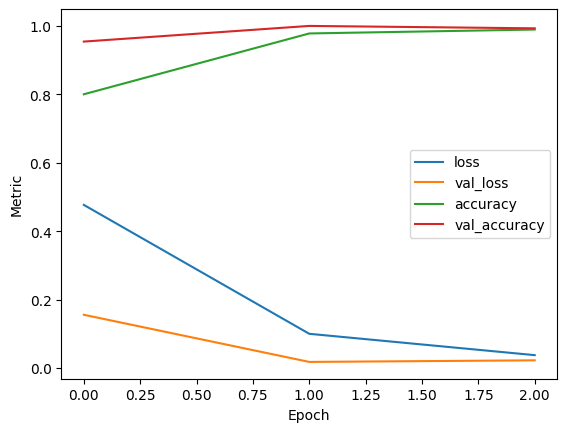

In [13]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()
plt.show()